In [1]:
def get_tree_percent(x):
    return x['geometry_tree'].intersection(x['geometry']).area/x['geometry'].area
#tract_taz['tract_pct'] = tract_taz[['geometry','geometry_taz']].apply(get_percent, axis = 1)


In [2]:
def ix2xy(r,c,gt):
    '''Gets x,y from row and column'''
    x = gt[0] + r * gt[1]
    y = gt[3] + c * gt[5]
    return(x,y)

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import gdal
import rasterio
import fiona
import rasterio.mask
from rastertodataframe import raster_to_dataframe
import itertools
import matplotlib.pyplot as plt

## Read in Image Data

In [4]:
boundaryDir = r'data\boundaries'
treeDir = r'data\trees'
img = 'delMar_2014_3_georeferenced.png'

In [5]:
delmar = gpd.read_file(os.path.join(boundaryDir,"DEL_MAR.shp"))
crs_ref  = rasterio.open(os.path.join('data','images',img)).crs
delmar = delmar.to_crs(crs_ref)

In [6]:
# Read in tree data into correct projection
dmtrees = gpd.read_file(os.path.join(treeDir,'delmar_trees.shp'))
dmtrees = dmtrees.to_crs(delmar.crs)
tree_mask = dmtrees.geometry.unary_union


## Process Raster Data

In [7]:
#crop del mar from image file
shapes = delmar['geometry']
with rasterio.open(os.path.join('data','images',img)) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [8]:
#save del mar raster
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(os.path.join('data','images',"delmar_masked_GE.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

In [9]:
#tree mask
dmt = rasterio.open(os.path.join('data','images','delmar_masked_GE.tif'))

In [10]:
# crop trees and 'not' trees
out_image_trees, out_transform_trees = rasterio.mask.mask(dmt, tree_mask, crop=True, invert = False)
out_meta_trees = dmt.meta
out_image_not_trees, out_transform_not_trees = rasterio.mask.mask(dmt, tree_mask, crop=False, invert = True)
out_meta_not_trees = dmt.meta


In [11]:
out_meta_trees.update({"driver": "GTiff",
                 "height": out_image_trees.shape[1],
                 "width": out_image_trees.shape[2],
                 "transform": out_transform_trees})

with rasterio.open(os.path.join('data','images',"delmar_masked_trees_GE.tif"), "w", **out_meta_trees) as dest:
    dest.write(out_image_trees)

In [12]:
out_meta_not_trees.update({"driver": "GTiff",
                 "height": out_image_not_trees.shape[1],
                 "width": out_image_not_trees.shape[2],
                 "transform": out_transform_not_trees})

with rasterio.open(os.path.join('data','images',"delmar_masked_not_trees_GE.tif"), "w", **out_meta_not_trees) as dest:
    dest.write(out_image_not_trees)

# Load Training Data

In [13]:
#ds = gdal.Open(os.path.join('data','images','delmar_masked.tif'))
#gt = ds.GetGeoTransform()


#df = pd.DataFrame.from_records(itertools.product(range(ds.RasterYSize),range(ds.RasterXSize)),columns=['Row','Column'])

#ds = None

#df['X'], df['Y'] = zip(*df.apply(lambda x: ix2xy(x['Column'],x['Row'],gt),axis=1))

In [14]:
# Load Trees to DataFrame
dmtgrtree = raster_to_dataframe(os.path.join('data','images','delmar_masked_trees_GE.tif'))
dmtgrtree['tree'] = 1

In [15]:
# Load Not Trees to DataFrame
dmtgrntree = raster_to_dataframe(os.path.join('data','images','delmar_masked_not_trees_GE.tif'))
dmtgrntree['tree'] = 0

In [35]:
# clip no data values
dmtgrtree['summy'] = dmtgrtree.Band_1+dmtgrtree.Band_2+dmtgrtree.Band_3#+dmtgrtree.Band_4
dmtgrntree['summy'] = dmtgrntree.Band_1+dmtgrntree.Band_2+dmtgrntree.Band_3#+dmtgrntree.Band_4
tree_training = pd.concat([dmtgrtree[dmtgrtree.summy >0],dmtgrntree[dmtgrntree.summy > 0]], axis = 0)
tree_training = tree_training[['Band_1','Band_2','Band_3','tree']].rename(columns = {'Band_1':'R','Band_2':'G','Band_3':'B'})

In [36]:
# Calculate Ratios
bands = ['R','G','B']#, 'Band_4']
for b in bands:
    for r in bands:
        if b==r: continue
        tree_training['{}_{}'.format(b,r)] = tree_training[b]/tree_training[r]

In [37]:
# Check Correlations
tree_training = tree_training.replace([np.inf, -np.inf], np.nan)
tree_training = tree_training.fillna(0)
tree_training.corr(method = 'kendall')

,R,G,B,tree,R_G,R_B,G_R,G_B,B_R,B_G
R,1.000000,0.899072,0.846769,-0.125335,0.153932,-0.263750,-0.153750,-0.444605,0.266622,0.447490
G,0.899072,1.000000,0.898994,-0.116350,0.045389,-0.342506,-0.045207,-0.462489,0.345384,0.465381
B,0.846769,0.898994,1.000000,-0.121660,0.033450,-0.424837,-0.033269,-0.571655,0.427721,0.574552
tree,-0.125335,-0.116350,-0.121660,1.000000,-0.079001,0.054447,0.078985,0.110904,-0.054677,-0.111130
R_G,0.153932,0.045389,0.033450,-0.079001,1.000000,0.379423,-0.999819,0.030730,-0.380059,-0.031353
R_B,-0.263750,-0.342506,-0.424837,0.054447,0.379423,1.000000,-0.379268,0.652622,-0.997127,-0.649762
G_R,-0.153750,-0.045207,-0.033269,0.078985,-0.999819,-0.379268,1.000000,-0.030549,0.380240,0.031534
G_B,-0.444605,-0.462489,-0.571655,0.110904,0.030730,0.652622,-0.030549,1.000000,-0.649749,-0.997114
B_R,0.266622,0.345384,0.427721,-0.054677,-0.380059,-0.997127,0.380240,-0.649749,1.000000,0.652635
B_G,0.447490,0.465381,0.574552,-0.111130,-0.031353,-0.649762,0.031534,-0.997114,0.652635,1.000000


In [38]:
tree_training.corr(method = 'kendall').to_csv('ge_corr.csv')

# Load Model

In [19]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [20]:
tree_training.to_csv('google_earth_tree_training.csv',index = False)

In [21]:
X = tree_training[['Band_1','Band_2','Band_3','Band_3_Band_2']]
y = tree_training.tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.485690
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.028      
Dependent Variable: tree             AIC:              602174.0152
Date:               2020-05-02 18:04 BIC:              602219.3645
No. Observations:   619908           Log-Likelihood:   -3.0108e+05
Df Model:           3                LL-Null:          -3.0990e+05
Df Residuals:       619904           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Band_1            -0.0366   0.0005 -69.2311 0.0000 -0.0376 -0.0356
Band_2             0.0366   0.0007  50.0549 0.0000  0

In [23]:
logreg = LogisticRegression(random_state=0,max_iter=200)
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[148358    483]
 [ 37057     75]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    148841
           1       0.13      0.00      0.00     37132

    accuracy                           0.80    185973
   macro avg       0.47      0.50      0.45    185973
weighted avg       0.67      0.80      0.71    185973



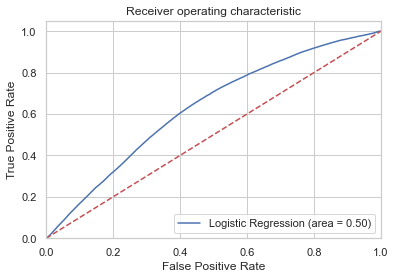

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_ge')
plt.show()

In [27]:
tree_training.tree.sum()/len(tree_training)

0.1996489801712512

In [28]:
tree_mask.area/delmar.iloc[0].geometry.area


0.21198705662717782

In [29]:
predict = logr
eg.predict(X)
predict.sum()/len(predict)

0.0027746052640069173

In [31]:
nt = pd.read_csv('naip_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_3_Band_2']])
predict.sum()/len(predict)

0.020240632352465104

In [32]:
nt = pd.read_csv('hro_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_3_Band_2']])
predict.sum()/len(predict)

0.00046577592589361474